# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

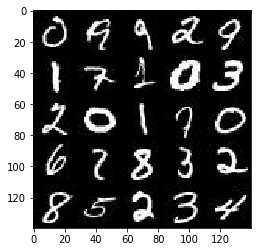

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

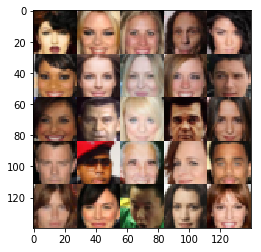

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    lr = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [53]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        
        # 14x14x64
        x1 = tf.layers.conv2d(inputs = images, filters = 64, kernel_size = 5, strides = 2, padding = 'same')
        lrelu1 = tf.maximum(alpha * x1, x1)       #leaky relu
        
        # 7x7x128
        x2 = tf.layers.conv2d(inputs = lrelu1, filters = 128, kernel_size = 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * x2, x2)       #leaky relu
        
        # 4x4x256
        x3 = tf.layers.conv2d(inputs = lrelu2, filters = 256, kernel_size = 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * x3, x3)       #leaky relu
        
        # flatten it
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [54]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # reshaping to start of convolutional stack
        # unflatten layer
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        lrelu1 = tf.maximum(alpha * x1, x1)       #leaky relu
        
        # 7X7x128
        x2 = tf.layers.conv2d_transpose(inputs=lrelu1, filters=128, kernel_size=1, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        lrelu2 = tf.maximum(alpha * x2, x2)       #leaky relu
        
        # 14x14x64
        x3 = tf.layers.conv2d_transpose(inputs=lrelu2, filters=64, kernel_size=3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        lrelu3 = tf.maximum(alpha * x3, x3)       #leaky relu
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(inputs=lrelu3, filters=out_channel_dim, kernel_size=3, strides=2, padding='same')       
        out = tf.tanh(logits)
        
    return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [55]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate*2, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [58]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real : batch_images, input_z : batch_z})
                _ = sess.run(g_opt, feed_dict={input_z : batch_z})
            
                if steps % 10 == 0:
                    # At the end of each 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr:learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    # At the end of each 100 epochs, show generator output
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3584... Generator Loss: 5.7258
Epoch 1/2... Discriminator Loss: 4.3290... Generator Loss: 0.0837
Epoch 1/2... Discriminator Loss: 3.1857... Generator Loss: 3.0090
Epoch 1/2... Discriminator Loss: 3.5490... Generator Loss: 0.0631
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 0.3271
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 2.5189
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.5761
Epoch 1/2... Discriminator Loss: 0.6697... Generator Loss: 2.8387
Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 1.2378


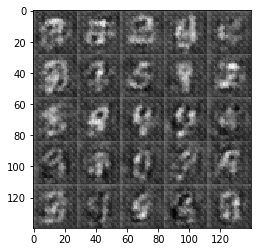

Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 0.6200... Generator Loss: 0.9291
Epoch 1/2... Discriminator Loss: 2.2345... Generator Loss: 0.1348
Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.5569... Generator Loss: 0.5373
Epoch 1/2... Discriminator Loss: 1.7612... Generator Loss: 2.4728
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 0.5820
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 2.0088... Generator Loss: 0.1740
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.7485


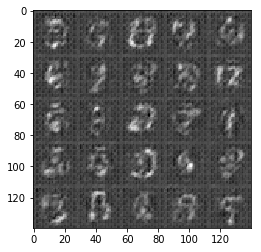

Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.5433
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 1.6169... Generator Loss: 3.2785
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 1.7396
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 1.0429
Epoch 1/2... Discriminator Loss: 0.8888... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 3.6439
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 1.8781
Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 0.5489


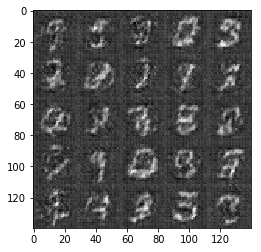

Epoch 1/2... Discriminator Loss: 0.5277... Generator Loss: 1.7586
Epoch 1/2... Discriminator Loss: 0.5333... Generator Loss: 2.4154
Epoch 1/2... Discriminator Loss: 0.4071... Generator Loss: 1.4432
Epoch 1/2... Discriminator Loss: 1.4341... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 0.7493... Generator Loss: 1.2957
Epoch 1/2... Discriminator Loss: 0.7117... Generator Loss: 0.8690
Epoch 1/2... Discriminator Loss: 0.1811... Generator Loss: 2.6364
Epoch 1/2... Discriminator Loss: 5.2311... Generator Loss: 7.0414
Epoch 1/2... Discriminator Loss: 1.1182... Generator Loss: 0.6670
Epoch 1/2... Discriminator Loss: 1.7187... Generator Loss: 3.1220


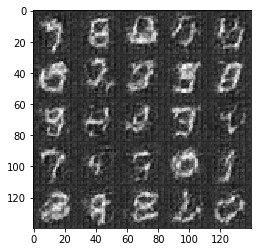

Epoch 1/2... Discriminator Loss: 0.6881... Generator Loss: 1.3348
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 0.1955... Generator Loss: 2.5281
Epoch 1/2... Discriminator Loss: 0.1209... Generator Loss: 3.1467
Epoch 1/2... Discriminator Loss: 0.1345... Generator Loss: 3.0644
Epoch 1/2... Discriminator Loss: 0.0849... Generator Loss: 3.0545
Epoch 2/2... Discriminator Loss: 0.0719... Generator Loss: 4.0157
Epoch 2/2... Discriminator Loss: 2.0359... Generator Loss: 3.8827
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 0.9613


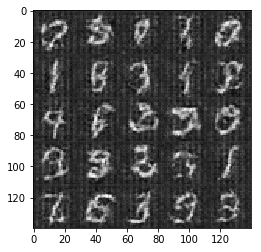

Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.1211... Generator Loss: 1.1451
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 1.4685
Epoch 2/2... Discriminator Loss: 0.9032... Generator Loss: 1.0520
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 1.7810
Epoch 2/2... Discriminator Loss: 1.7065... Generator Loss: 2.9997
Epoch 2/2... Discriminator Loss: 1.0241... Generator Loss: 0.6123
Epoch 2/2... Discriminator Loss: 0.7864... Generator Loss: 1.4880
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 2.2757
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 0.8291


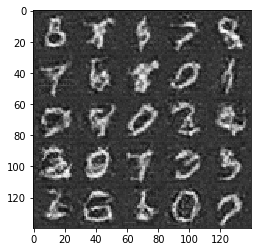

Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.3649
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 0.7919... Generator Loss: 1.5489
Epoch 2/2... Discriminator Loss: 0.5937... Generator Loss: 1.0378
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 1.1778
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 1.2712
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 0.5983
Epoch 2/2... Discriminator Loss: 0.6861... Generator Loss: 1.5835
Epoch 2/2... Discriminator Loss: 0.6012... Generator Loss: 1.1696


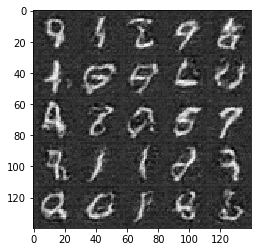

Epoch 2/2... Discriminator Loss: 0.4205... Generator Loss: 1.6875
Epoch 2/2... Discriminator Loss: 1.8116... Generator Loss: 4.9740
Epoch 2/2... Discriminator Loss: 0.7090... Generator Loss: 1.1516
Epoch 2/2... Discriminator Loss: 0.4758... Generator Loss: 1.4404
Epoch 2/2... Discriminator Loss: 0.3261... Generator Loss: 1.6228
Epoch 2/2... Discriminator Loss: 0.2330... Generator Loss: 1.9771
Epoch 2/2... Discriminator Loss: 0.4288... Generator Loss: 1.3352
Epoch 2/2... Discriminator Loss: 0.4492... Generator Loss: 1.3303
Epoch 2/2... Discriminator Loss: 0.6253... Generator Loss: 2.9710
Epoch 2/2... Discriminator Loss: 0.2869... Generator Loss: 2.0080


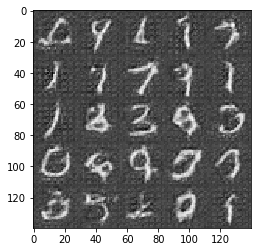

Epoch 2/2... Discriminator Loss: 0.1634... Generator Loss: 2.3652
Epoch 2/2... Discriminator Loss: 0.0620... Generator Loss: 3.8616
Epoch 2/2... Discriminator Loss: 0.0661... Generator Loss: 3.5845
Epoch 2/2... Discriminator Loss: 0.0434... Generator Loss: 4.7857
Epoch 2/2... Discriminator Loss: 0.0241... Generator Loss: 5.2544
Epoch 2/2... Discriminator Loss: 0.1670... Generator Loss: 2.3601
Epoch 2/2... Discriminator Loss: 0.1845... Generator Loss: 2.1524
Epoch 2/2... Discriminator Loss: 0.0263... Generator Loss: 4.8930
Epoch 2/2... Discriminator Loss: 0.1200... Generator Loss: 2.5970
Epoch 2/2... Discriminator Loss: 0.0454... Generator Loss: 3.9239


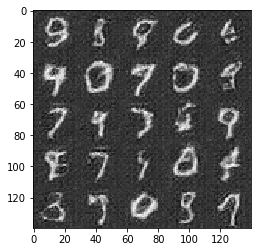

Epoch 2/2... Discriminator Loss: 0.0403... Generator Loss: 5.3076
Epoch 2/2... Discriminator Loss: 0.0419... Generator Loss: 3.7430
Epoch 2/2... Discriminator Loss: 0.0137... Generator Loss: 5.6225


In [59]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 2.6251
Epoch 1/1... Discriminator Loss: 2.1327... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 1.8249... Generator Loss: 0.3084
Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 2.0034
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 2.4959
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 2.1323
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.6634... Generator Loss: 2.1288
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.7096


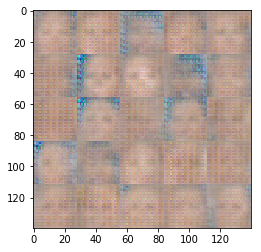

Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 2.1909
Epoch 1/1... Discriminator Loss: 1.7499... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.6589... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 2.2457
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.8824... Generator Loss: 2.0453
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.7526


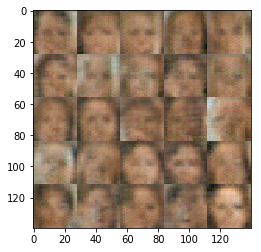

Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 2.8057... Generator Loss: 0.0785
Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 3.2561... Generator Loss: 4.8153


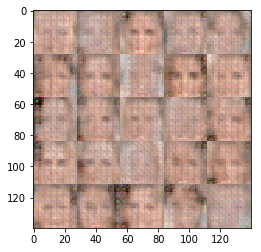

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 4.3792
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 2.5842
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 2.1376
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 5.3233


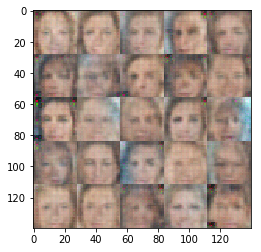

Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.5181


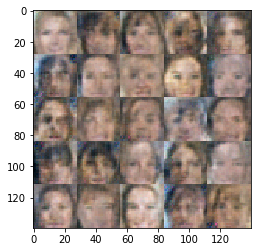

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 1.5067
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.3679
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.5588


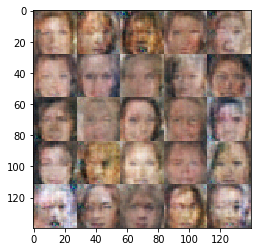

Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 5.2102... Generator Loss: 5.4413
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.8035


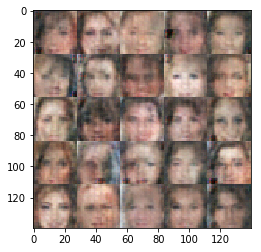

Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.6739... Generator Loss: 0.2926
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7225


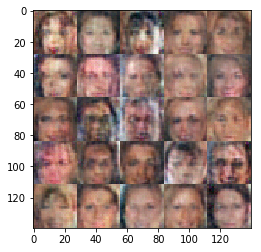

Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.6794


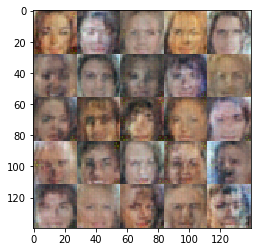

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.8158


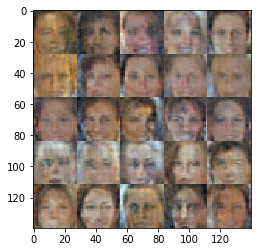

Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.4367


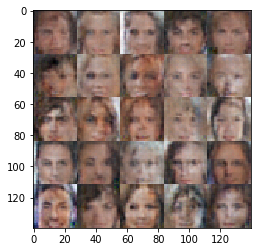

Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.6866... Generator Loss: 0.2903
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.7958... Generator Loss: 0.2349


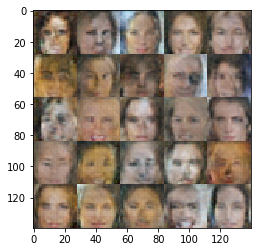

Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.3557
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 0.7324


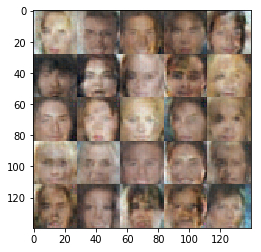

Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.2458


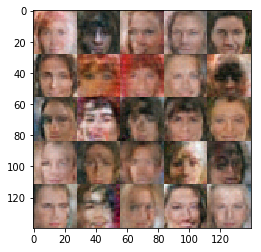

Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7269


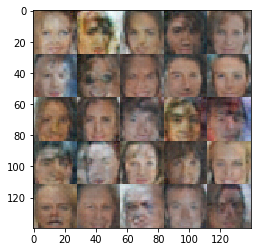

Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 1.8831... Generator Loss: 0.2391
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 1.6883
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.9930
Epoch 1/1... Discriminator Loss: 1.7149... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.4667


In [60]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.